In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import (delete_ds_store,plot_metrics,test,train,set_device,mean_std_finder,load_model)
from CBAM_CAM_DA import _CBAM_CAM_DA
from MBNV3_v2 import MBNV3_Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM_CAM_DA,
    "module_alias": "CBAM_CAM_DA",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_100/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 100,
    "epochs": 50,
    "learning_rate": 0.0001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"], module = prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/818f2c4495f74ed2908f0419842e531e



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


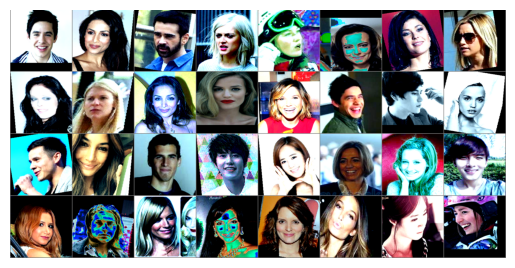

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build_model(), prms["model_save_path"]) if prms["load_model"] else model.build_model()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

Model modified with custom module: <class 'CBAM_CAM_DA._CBAM_CAM_DA'> in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
model_summary = summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=10)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
prms["experiment"].log_metric("total_params", total_params) if prms["experiment"] else None

model_summary

/Users/leo/Desktop/Thesis/thesis_env/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                          [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
├─Sequential (features)                            [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                    [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                        [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --                   32                   True
│    │    └─Hardswish (2)    

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch: 01 | Epoch Time: 2.0m 38s
	Train Loss: 3.673 | Train Acc: 5.20%
	 Val. Loss: 3.354 |  Val. Acc: 9.41%
Best Accuracy Achieved: 9.41% on epoch 01


100%|██████████| 93/93 [00:08<00:00, 10.37it/s]


Epoch: 02 | Epoch Time: 2.0m 37s
	Train Loss: 3.270 | Train Acc: 12.69%
	 Val. Loss: 2.947 |  Val. Acc: 18.56%
Best Accuracy Achieved: 18.56% on epoch 02


100%|██████████| 93/93 [00:10<00:00,  9.00it/s]


Epoch: 03 | Epoch Time: 2.0m 37s
	Train Loss: 2.992 | Train Acc: 18.39%
	 Val. Loss: 2.701 |  Val. Acc: 25.02%
Best Accuracy Achieved: 25.02% on epoch 03


100%|██████████| 93/93 [00:08<00:00, 10.34it/s]


Epoch: 04 | Epoch Time: 3.0m 20s
	Train Loss: 2.801 | Train Acc: 23.10%
	 Val. Loss: 2.509 |  Val. Acc: 29.09%
Best Accuracy Achieved: 29.09% on epoch 04


100%|██████████| 93/93 [00:08<00:00, 10.74it/s]


Epoch: 05 | Epoch Time: 2.0m 33s
	Train Loss: 2.644 | Train Acc: 26.66%
	 Val. Loss: 2.452 |  Val. Acc: 31.34%
Best Accuracy Achieved: 31.34% on epoch 05


100%|██████████| 93/93 [00:08<00:00, 11.15it/s]


Epoch: 06 | Epoch Time: 2.0m 33s
	Train Loss: 2.504 | Train Acc: 30.19%
	 Val. Loss: 2.294 |  Val. Acc: 36.55%
Best Accuracy Achieved: 36.55% on epoch 06


100%|██████████| 93/93 [00:08<00:00, 10.95it/s]


Epoch: 07 | Epoch Time: 2.0m 32s
	Train Loss: 2.396 | Train Acc: 32.74%
	 Val. Loss: 2.217 |  Val. Acc: 36.85%
Best Accuracy Achieved: 36.85% on epoch 07


100%|██████████| 93/93 [00:08<00:00, 11.06it/s]


Epoch: 08 | Epoch Time: 2.0m 28s
	Train Loss: 2.268 | Train Acc: 35.59%
	 Val. Loss: 2.130 |  Val. Acc: 39.91%
Best Accuracy Achieved: 39.91% on epoch 08


100%|██████████| 93/93 [00:08<00:00, 11.07it/s]


Epoch: 09 | Epoch Time: 2.0m 27s
	Train Loss: 2.177 | Train Acc: 38.68%
	 Val. Loss: 2.025 |  Val. Acc: 43.31%
Best Accuracy Achieved: 43.31% on epoch 09


100%|██████████| 93/93 [00:08<00:00, 10.87it/s]


Epoch: 10 | Epoch Time: 2.0m 29s
	Train Loss: 2.078 | Train Acc: 41.07%
	 Val. Loss: 1.911 |  Val. Acc: 45.06%
Best Accuracy Achieved: 45.06% on epoch 10


100%|██████████| 93/93 [00:08<00:00, 10.79it/s]


Epoch: 11 | Epoch Time: 2.0m 33s
	Train Loss: 1.974 | Train Acc: 43.81%
	 Val. Loss: 1.808 |  Val. Acc: 49.02%
Best Accuracy Achieved: 49.02% on epoch 11


100%|██████████| 93/93 [00:08<00:00, 11.08it/s]


Epoch: 12 | Epoch Time: 2.0m 31s
	Train Loss: 1.916 | Train Acc: 45.37%
	 Val. Loss: 1.808 |  Val. Acc: 48.79%


100%|██████████| 93/93 [00:08<00:00, 10.85it/s]


Epoch: 13 | Epoch Time: 2.0m 30s
	Train Loss: 1.833 | Train Acc: 47.65%
	 Val. Loss: 1.728 |  Val. Acc: 51.48%
Best Accuracy Achieved: 51.48% on epoch 13


 47%|████▋     | 344/736 [01:06<01:18,  5.00it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])